In [22]:
from networks.adversarial_model import EncoderDecoder
import torch
import numpy as np
import scipy.io
import torch.nn as nn
from networks.gan import Generator, Generator256, Generator512
from nn_descent_gan import NAE, cost_func, get_tensor, outer, generate


In [30]:

X = scipy.io.loadmat('data/T.mat')['T']
C = scipy.io.loadmat('data/C.mat')['C']
W = scipy.io.loadmat('data/Om.mat')['Om']
S_tilde = scipy.io.loadmat('data/S_omega.mat')['S_omega']
S_true = scipy.io.loadmat('data/Sc.mat')['S_true']
Strue_raw = scipy.io.loadmat('data/Sc.mat')['S_true']
R = C.shape[1]
# # ans = run_descent(O_mat, T, S_tensor, C, C.shape[1])
# ans = inverse_gan(W, X, S_tilde, C, R, S_true)
# print(ans.shape)


In [24]:
from nn_descent_ae import model, model_log
ae_out = model(S_tilde, W, R)
ae_log_out = model_log(S_tilde, W,R)

In [25]:
NAE(ae_out, Strue_raw)

0.5427075884147354

In [31]:
from IPython.display import clear_output
from slf_dataset import plot_image_output
import time

loop_count = 500
z_dimension = 256
criterion = nn.L1Loss()

generator = Generator256()
GAN_PATH = '/home/sagar/Projects/radio_map_deep_prior/deep_prior/trained-models/gan/sngan7_256'
checkpoint = torch.load(GAN_PATH, map_location=torch.device('cpu'))
generator.load_state_dict(checkpoint['g_model_state_dict'])
generator.eval()
generator = generator.to('cpu')

# Prepare data
W = torch.from_numpy(W).type(torch.float32)
X = torch.from_numpy(X).type(torch.float32)
S_tilde = torch.from_numpy(S_tilde).type(torch.float32)
S_true = torch.from_numpy(S_true).type(torch.float32)

C = torch.from_numpy(C).type(torch.float32)
R = int(R)


K = X.shape[2]

X = X.permute(2,0,1)
C = C.permute(1,0)

S = S_true.permute(2,0,1)
S_true = S_true.permute(2,0,1)

S_true[S_true<0] = 0
S_true = torch.log(S_true.unsqueeze(dim=1) + 1e-16)
S_true[S_true<-30] = 0

S_tilde = S_tilde.permute(2,0,1)
S_tilde[S_tilde<0] = 0
S_tilde = torch.log(S_tilde.unsqueeze(dim=1)+1e-16)
S_tilde[S_tilde<-30] = 0

normalizer = []
for i in range(R):
    normalizer.append(S_true[i].min().item())
    S_tilde[i] = S_tilde[i]/S_true[i].min()
    S_true[i] = S_true[i]/S_true[i].min()

# save normalization
a = torch.ones((R,1,51,51), dtype=torch.float32)
for i in range(R):
    a[i] = a[i]*normalizer[i]

W = W.unsqueeze(dim=0)
W = W.unsqueeze(dim=0)
Wr = W.repeat(R,1,1,1)
Wx = W.repeat(K,1,1,1)

Wr[Wr<0.5] = 0
Wr[Wr>=0.5] = 1
Wx[Wx<0.5] = 0
Wx[Wx>=0.5] = 1
Wx = Wx.squeeze()
print(Wx.shape)
W = W.squeeze(dim=0)
print("shape of W is {}".format(W.shape))
Z = torch.zeros((1,z_dimension), dtype=torch.float32)
# First select a good random vector
for r in range(R):
    z = torch.randn((1,z_dimension), dtype=torch.float32)
    min_criterion = 9999999
    print('starting opt')
    for i in range(400):
        temp = torch.randn((1,z_dimension), dtype=torch.float32)
        temp_out = generator(temp)
        
        temp_criterion = criterion((W*S_tilde[r]), (W*temp_out))

        if  temp_criterion < min_criterion:
            z.data = temp.clone()
            min_criterion = temp_criterion
            print('min_first', min_criterion)

    for i in range(200):
        temp = 0.2*torch.randn((1,z_dimension), dtype=torch.float32) + z
        temp_out = generator(temp)

        temp_criterion = criterion((W*S_tilde[r]), (W*temp_out))
        if  temp_criterion < min_criterion:
            z.data = temp.clone()
            min_criterion = temp_criterion
            print('min_second', min_criterion)

    z.requires_grad = True
    optimizer = torch.optim.Adam([z], lr=0.01)

    for i in range(loop_count):
        optimizer.zero_grad()

        gen_out = generator(z)
#         gen_out = torch.exp(gen_out*a)
        loss = criterion((W*S_tilde[r]), (W*gen_out))

        print(loss)
        loss.backward()
        optimizer.step()
        if print_out:
            clear_output(wait=True)
            print(r)
            plot_image_output(gen_out)
            plt.show()
#             time.sleep(0.1)

    z = z.detach()
    Z = torch.cat((Z,z), dim=0)
# z = z.detach().numpy()
Z = Z[1:].numpy()
gen_out = generate(Z, a)

print('shape of Z is {}'.format(Z.shape))
# gen_out = gen_out[:,0,:,:]
# gen_out = gen_out.permute(1,2,0)
# gen_out = gen_out.detach().numpy()

# return z.copy(), gen_out.copy() 


torch.Size([64, 51, 51])
shape of W is torch.Size([1, 51, 51])
starting opt
min_first tensor(0.0234, grad_fn=<L1LossBackward>)
min_first tensor(0.0200, grad_fn=<L1LossBackward>)
min_first tensor(0.0165, grad_fn=<L1LossBackward>)
min_first tensor(0.0154, grad_fn=<L1LossBackward>)
min_first tensor(0.0083, grad_fn=<L1LossBackward>)
min_first tensor(0.0062, grad_fn=<L1LossBackward>)


/home/sagar/Projects/radio_map_deep_prior/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([1, 1, 51, 51])) that is different to the input size (torch.Size([1, 51, 51])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


min_second tensor(0.0060, grad_fn=<L1LossBackward>)
min_second tensor(0.0059, grad_fn=<L1LossBackward>)
min_second tensor(0.0058, grad_fn=<L1LossBackward>)
min_second tensor(0.0058, grad_fn=<L1LossBackward>)
min_second tensor(0.0056, grad_fn=<L1LossBackward>)
min_second tensor(0.0053, grad_fn=<L1LossBackward>)
min_second tensor(0.0053, grad_fn=<L1LossBackward>)
min_second tensor(0.0052, grad_fn=<L1LossBackward>)
min_second tensor(0.0052, grad_fn=<L1LossBackward>)
min_second tensor(0.0051, grad_fn=<L1LossBackward>)
min_second tensor(0.0051, grad_fn=<L1LossBackward>)
min_second tensor(0.0051, grad_fn=<L1LossBackward>)
min_second tensor(0.0050, grad_fn=<L1LossBackward>)
min_second tensor(0.0049, grad_fn=<L1LossBackward>)
min_second tensor(0.0049, grad_fn=<L1LossBackward>)
min_second tensor(0.0048, grad_fn=<L1LossBackward>)
min_second tensor(0.0048, grad_fn=<L1LossBackward>)
min_second tensor(0.0047, grad_fn=<L1LossBackward>)
min_second tensor(0.0047, grad_fn=<L1LossBackward>)
min_second t

tensor(0.0033, grad_fn=<L1LossBackward>)
tensor(0.0033, grad_fn=<L1LossBackward>)
tensor(0.0033, grad_fn=<L1LossBackward>)
tensor(0.0033, grad_fn=<L1LossBackward>)
tensor(0.0033, grad_fn=<L1LossBackward>)
tensor(0.0032, grad_fn=<L1LossBackward>)
tensor(0.0032, grad_fn=<L1LossBackward>)
tensor(0.0032, grad_fn=<L1LossBackward>)
tensor(0.0032, grad_fn=<L1LossBackward>)
tensor(0.0032, grad_fn=<L1LossBackward>)
tensor(0.0032, grad_fn=<L1LossBackward>)
tensor(0.0032, grad_fn=<L1LossBackward>)
tensor(0.0032, grad_fn=<L1LossBackward>)
tensor(0.0032, grad_fn=<L1LossBackward>)
tensor(0.0032, grad_fn=<L1LossBackward>)
tensor(0.0032, grad_fn=<L1LossBackward>)
tensor(0.0032, grad_fn=<L1LossBackward>)
tensor(0.0032, grad_fn=<L1LossBackward>)
tensor(0.0032, grad_fn=<L1LossBackward>)
tensor(0.0032, grad_fn=<L1LossBackward>)
tensor(0.0032, grad_fn=<L1LossBackward>)
tensor(0.0032, grad_fn=<L1LossBackward>)
tensor(0.0032, grad_fn=<L1LossBackward>)
tensor(0.0032, grad_fn=<L1LossBackward>)
tensor(0.0032, g

tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, grad_fn=<L1LossBackward>)
tensor(0.0029, g

tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0026, grad_fn=<L1LossBackward>)
tensor(0.0025, grad_fn=<L1LossBackward>)
tensor(0.0025, grad_fn=<L1LossBackward>)
tensor(0.0025, grad_fn=<L1LossBackward>)
tensor(0.0025, grad_fn=<L1LossBackward>)
tensor(0.0025, g

tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, grad_fn=<L1LossBackward>)
tensor(0.0023, g

In [33]:
NAE(gen_out, Strue_raw)

1.3040822956326545

In [22]:
r=1
import matplotlib.pyplot as plt

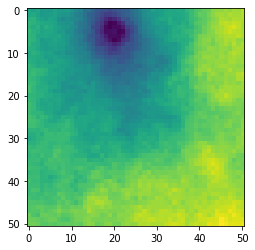

In [23]:
plt.imshow(S_true[r,0])

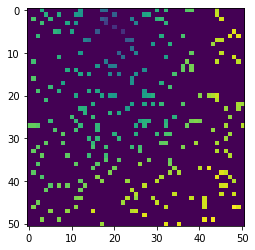

In [24]:
plt.imshow(S_tilde[r,0,:,:])

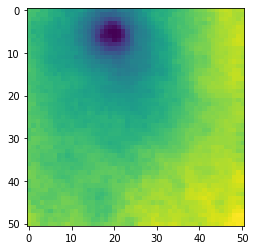

In [25]:
plt.imshow(-np.log(gen_out[:,:,r]))

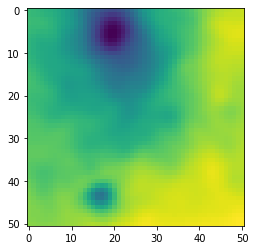

In [26]:
plt.imshow(-np.log(ae_log_out[:,:,r]))

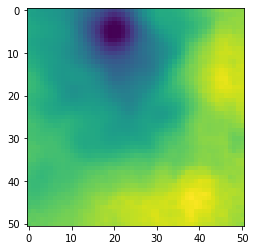

In [27]:
plt.imshow(-np.log(ae_out[:,:,r]))

In [28]:
S_true = scipy.io.loadmat('data/Sc.mat')['S_true']

In [12]:
Sr = gen_out
S = S_true

In [15]:
Sr.shape

(51, 51, 2)

In [35]:
Sr = ae_out